# Inverse Kinematics for a robot arm in Mujoco

In [1]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media

## Load Model

In [2]:
# load model
xml = "../mujoco_menagerie/universal_robots_ur5e/scene.xml" # add your path
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

## Setup Camera

In [3]:
# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1

## Get a test point for my end effector

[ 4.71238898 -1.57079633  1.57079633  4.71238898  4.71238898  0.        ]
[0.492 0.134 0.588]


""

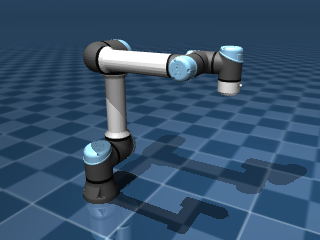

In [4]:
#put random position of the joints
pi = np.pi
data.qpos = [3*pi/2, -pi/2, pi/2, 3*pi/2, 3*pi/2, 0]

# inititial joint position
qpos0 = data.qpos.copy()
print(qpos0)

# Step the simulation.
mujoco.mj_forward(model, data)

# get the end effector position in cartesian variables
test_point = data.body('wrist_3_link').xpos
print(test_point)

#plot robot
renderer.update_scene(data, camera)
media.show_image(renderer.render())

sin IK
test point [0.492 0.134 0.588]
deseado [ 4.71238898 -1.57079633  1.57079633  4.71238898  4.71238898  0.        ]


""

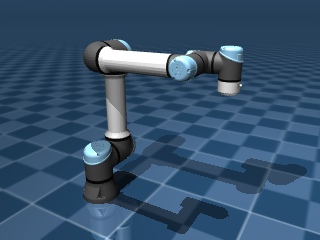

con IK
point result [-0.02594613  0.88659811  0.19465404]
resultado [-0.12239902  0.0150484  -0.28646566 -0.56456805  0.          0.        ]


""

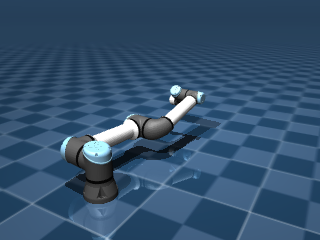

In [12]:
def inverse_kinematics(model, data, body_id, goal_pose, qpos0, step_size, tol, alpha, jacp, jacr):
    
    def check_joint_limits(q):
        #TODO: terminar chequeo de limites de los angulos
        
    data.qpos = qpos0
    mujoco.mj_forward(model, data)
    current_pose = data.body('wrist_3_link').xpos
    
    error = np.subtract(goal_pose, current_pose)
    
    while (np.linalg.norm(error) >= tol):
        mujoco.mj_jac(model, data, jacp, jacr, goal_pos, body_id) # calculate jacobians
        grad = alpha * Jacp.T @ error
        data.qpos += step_size * grad
        
        check_joint_limits(data.qpos)
        
        mujoco.mj_foward(model, data) #compute forward kinematics
        error = np.subtract(goal_pose, data.body('wrist_3_link').xpos)
        

    
# Init variables.
body_id = model.body('wrist_3_link').id
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian

#get desire point
mujoco.mj_resetDataKeyframe(model, data, 1)
inverse_kinematics(model, data, body_id, goal_pose, step_size, tol, alpha, jacp, jacr)

result = data.qpos.copy()

print("sin IK")
data.qpos = qpos0
mujoco.mj_forward(model, data)
print("test point", test_point)
print('deseado', qpos0)
renderer.update_scene(data, camera)
media.show_image(renderer.render())

print("con IK")
data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.body('wrist_3_link').xpos
print('point result', result_point)
print('resultado', result)
renderer.update_scene(data, camera)
media.show_image(renderer.render())